# RNN - Counting Bits

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


## 1. Dataset

In [90]:
def construct_binary_seq_dataset(num_seq=1e5, seq_min_len=1, seq_max_len=16):
    # bin seq of lengths between seq_min_len and seq_max_len
    # returns (sequence, count of 1s in sequence) pairs
    data = []

    for i in range(int(num_seq)):
        if seq_min_len == seq_max_len:
            seq_len = seq_min_len
        else:
            seq_len = np.random.randint(seq_min_len, seq_max_len+1)

        seq = np.random.randint(0, 2, seq_len)
        data.append((seq, np.sum(seq)))


    return data

def split_bin_seq_data(data):
    # split the dataset into train(0.8), val(0.1), test(0.1)
    np.random.shuffle(data)
    split1 = int(0.8 * len(data))
    split2 = int(0.9 * len(data))
    train_data = data[:split1]
    val_data = data[split1:split2]
    test_data = data[split2:]

    return train_data, val_data, test_data


train_bin_seq_data, val_bin_seq_data, test_bin_seq_data = split_bin_seq_data(construct_binary_seq_dataset(num_seq=1e5, seq_min_len=1, seq_max_len=16))

`Examples from the data`

In [91]:
print("Train data: ", len(train_bin_seq_data))
print("Val data: ", len(val_bin_seq_data))
print("Test data: ", len(test_bin_seq_data))

# report examples

print("\nExamples: [sequence] count_of_1s")
for i in range(5):
    print(train_bin_seq_data[i][0], "------->", train_bin_seq_data[i][1])
    print(val_bin_seq_data[i][0], "------->", val_bin_seq_data[i][1])
    print(test_bin_seq_data[i][0], "------->", test_bin_seq_data[i][1])


Train data:  80000
Val data:  10000
Test data:  10000

Examples: [sequence] count_of_1s
[1 0 0 1] -------> 2
[1 1 0 0 1 1 1 0 0 0 1 1] -------> 7
[1 0 0] -------> 1
[1 0 0 1 1 0 1 1] -------> 5
[1 0 0 1] -------> 2
[0 1 1 1 0 1 0 0 0 1 1] -------> 6
[1 0 1 0 1 1 0 0 0 0 0 1 1 1] -------> 7
[1 1 1 1 1 1] -------> 6
[0 0 0 1 0 0 0] -------> 1
[0 0 0] -------> 0
[0 0 0] -------> 0
[1 0 1] -------> 2
[1 0 1] -------> 2
[1 0 0 1 0 0] -------> 2
[0 1 1 0 1 1 1] -------> 5


`Distribution of the data across different length of sequences`

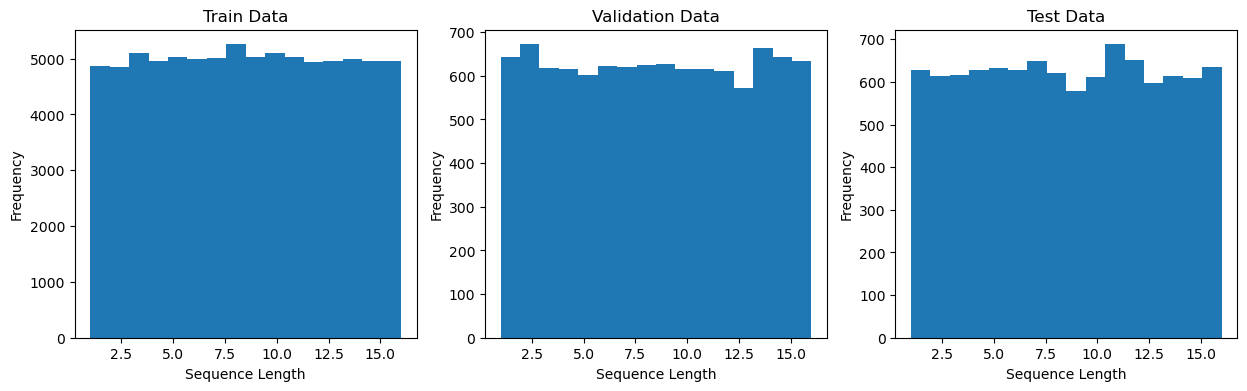

In [93]:
# distribution of sequence lengths in the dataset (train, val, test) - subplot

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
seq_lens = [len(data[0]) for data in train_bin_seq_data]
plt.hist(seq_lens, bins=16)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Train Data")

plt.subplot(1, 3, 2)
seq_lens = [len(data[0]) for data in val_bin_seq_data]
plt.hist(seq_lens, bins=16)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Validation Data")

plt.subplot(1, 3, 3)
seq_lens = [len(data[0]) for data in test_bin_seq_data]
plt.hist(seq_lens, bins=16)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Test Data")

plt.show()



In [94]:
class BinarySeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence, count = self.data[idx]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(count, dtype=torch.float32)
    
train_dataset = BinarySeqDataset(train_bin_seq_data)
val_dataset = BinarySeqDataset(val_bin_seq_data)
test_dataset = BinarySeqDataset(test_bin_seq_data)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)
test_loader = DataLoader(test_dataset, batch_size=1)




## 2. Architecture

In [95]:
class BinarySequenceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1, output_size=1, dropout=0.1):
        super(BinarySequenceRNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        
        out, _ = self.rnn(x)
        out = out[:, -1, :] # last time step
        out = self.fc(out)
        return out

The architecture of the model is as follows:

RNN with 1 hidden layer of size 16 followed by a fully connected layer with 1 output.  
The input size is 1 (since we are feeding one bit at a time) and the output size is also 1 (the number of 1's to be predicted).  
The forward function does the forward pass for the RNN, takes the last hidden state and passes it through the fully connected layer to get the output.

## 3. Training

In [ ]:
binary_seq_rnn = BinarySequenceRNN(input_size=1, hidden_size=16, num_layers=1, output_size=1, dropout=0.1)
# MAE loss
criterion = nn.L1Loss()
optimizer = optim.Adam(binary_seq_rnn.parameters(), lr=1e-5)

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accs = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (seq, count) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(seq.unsqueeze(-1))
            loss = criterion(output, count.unsqueeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for i, (seq, count) in enumerate(val_loader):
                output = model(seq.unsqueeze(-1))
                loss = criterion(output, count.unsqueeze(-1))
                val_loss += loss.item()
                val_acc += torch.sum(torch.abs(output - count.unsqueeze(-1)) <= 0.5).item() / len(count)
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            val_acc /= len(val_loader)
            val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return train_losses, val_losses, val_accs

train_losses, val_losses, val_accuracies = train(binary_seq_rnn, train_loader, val_loader, criterion, optimizer, num_epochs=10)


/opt/anaconda3/envs/smai_env/lib/python3.12/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10, Train Loss: 0.3736, Val Loss: 0.0892, Val Acc: 0.9852
Epoch 2/10, Train Loss: 0.0725, Val Loss: 0.0533, Val Acc: 0.9931
Epoch 3/10, Train Loss: 0.0589, Val Loss: 0.0374, Val Acc: 0.9957
Epoch 4/10, Train Loss: 0.0522, Val Loss: 0.0946, Val Acc: 0.9978
Epoch 5/10, Train Loss: 0.0496, Val Loss: 0.0254, Val Acc: 0.9978
Epoch 6/10, Train Loss: 0.0473, Val Loss: 0.0239, Val Acc: 0.9988
Epoch 7/10, Train Loss: 0.0452, Val Loss: 0.0419, Val Acc: 0.9988
Epoch 8/10, Train Loss: 0.0438, Val Loss: 0.0643, Val Acc: 0.9988
Epoch 9/10, Train Loss: 0.0417, Val Loss: 0.0239, Val Acc: 0.9988
Epoch 10/10, Train Loss: 0.0404, Val Loss: 0.0208, Val Acc: 0.9988


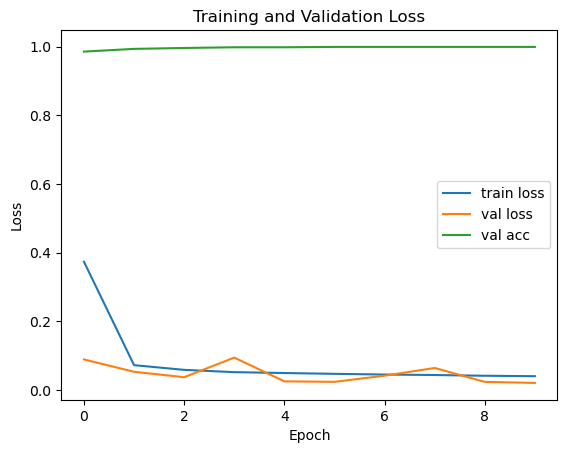

In [136]:
# plot losses
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.plot(val_accuracies, label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [161]:
# test
binary_seq_rnn.eval()
test_losses_1_16 = []
test_loss = 0.0
with torch.no_grad():
    for i, (seq, count) in enumerate(test_loader):
        output = binary_seq_rnn(seq.unsqueeze(-1))
        loss = criterion(output, count.unsqueeze(-1))
        test_loss += loss.item()
        # find the length of the sequence
        seq_len = (np.array(seq)).shape[1]
        test_losses_1_16.append([loss.item(), count.item(), output.item(), seq_len])
    test_loss /= len(test_loader)

print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.0211


`Comparison with random baseline`

In [145]:
# compare with random prediction
random_loss = 0.0
with torch.no_grad():
    for i, (seq, count) in enumerate(test_loader):
        output = torch.tensor(np.random.randint(0, 17), dtype=torch.float32)
        loss = criterion(output, count.unsqueeze(-1))
        random_loss += loss.item()
    random_loss /= len(test_loader)

print(f"Loss with random predictions: {random_loss:.4f}")

Loss with random predictions: 5.5010


The loss with random predictions (5.5010) is more than 100 times than the one given by RNN class (0.0211) which shows the ability of RNN in predicting the next binary digit in the sequence and hence the number of 1s in the sequence.

## 4. Generalization

In [162]:
bin_seq_17_32 = construct_binary_seq_dataset(num_seq=1e4, seq_min_len=17, seq_max_len=32)
bin_seq_17_32_dataset = BinarySeqDataset(bin_seq_17_32)
bin_seq_17_32_loader = DataLoader(bin_seq_17_32_dataset, batch_size=1)

binary_seq_rnn.eval()
test_loss_17_32 = 0.0
test_losses_17_32 = []
with torch.no_grad():
    for i, (seq, count) in enumerate(bin_seq_17_32_loader):
        output = binary_seq_rnn(seq.unsqueeze(-1))
        loss = criterion(output, count.unsqueeze(-1))
        test_loss_17_32 += loss.item()
        seq_len = (np.array(seq)).shape[1]
        test_losses_17_32.append([loss.item(), count.item(), output.item(), seq_len])
    test_loss_17_32 /= len(bin_seq_17_32_loader)

print(f"Test Loss (sequence length: 17-32): {test_loss_17_32:.4f}")


Test Loss (sequence length: 17-32): 1.4304


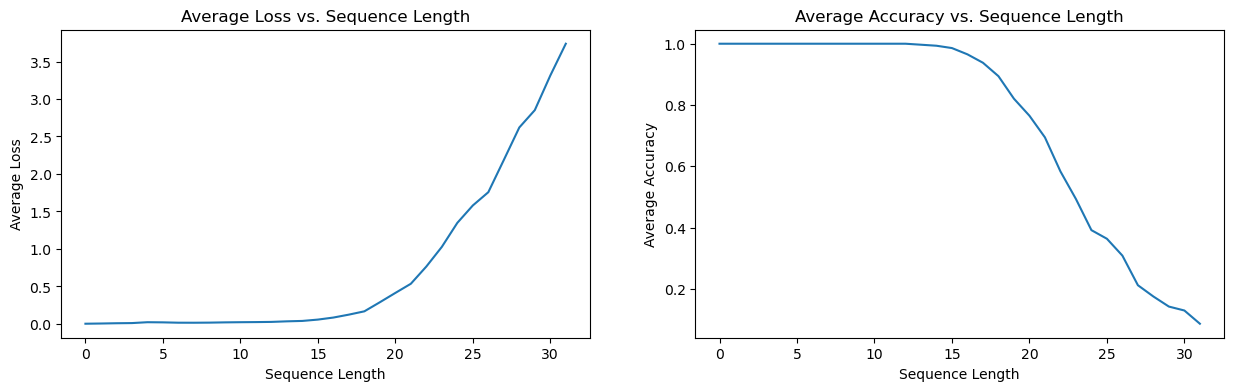

In [ ]:
# plot losses for seq_len 1 - 32
losses = test_losses_1_16 + test_losses_17_32

# for each sequence length from 1 to 32, average loss and accuracy
avg_losses = []
avg_accuracies = []

for i in range(1, 33):
    seq_losses = [loss[0] for loss in losses if loss[3] == i]
    avg_losses.append(np.mean(seq_losses))
    seq_accuracies = [1 if  abs(loss[1] - loss[2]) <= 0.5 else 0 for loss in losses if loss[3] == i]
    avg_accuracies.append(np.mean(seq_accuracies))

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_losses)
plt.xlabel("Sequence Length")
plt.ylabel("Average Loss")
plt.title("Average Loss vs. Sequence Length")

plt.subplot(1, 2, 2)
plt.plot(avg_accuracies)
plt.xlabel("Sequence Length")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy vs. Sequence Length")

plt.show()


The loss is close to zero and the accuracy is close to 1, until sequence length = 16, following which the loss starts increasing and the accuracy falls. This is because the model is trained on sequences of lengths 1 to 16 and hence it is able to predict the next digit in such sequences with high accuracy leading to a correct number of 1's predicted. But when the sequence length is increased, the model is not able to predict the next digit in the sequence with high accuracy leading to incorrect predictions. 

The reason for this is the vanishing gradient problem in RNNs. The gradients of the loss function with respect to the weights decrease exponentially with the sequence length. This makes it difficult for the model to learn the long term dependencies in the sequence (short term memory in RNNs). This can be solved by using LSTM (Long short-term memory) which is designed to retain information over longer sequences.